# Stable Diffsion Custom Pipeline
- 해당 코드는 Stable Diffusion을 사용하기 위해 Custom Pipeline을 구축한 코드이다.

## 1. Package install

## 2. Package import

In [2]:
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login

In [3]:
# GPU 설정
device = "cuda"

In [4]:
# 허깅페이스 로그인
notebook_login()

Login successful
Your token has been saved to C:\Users\Park Ji Seong\.huggingface\token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


## 3. Custom Stable Diffusion Pipline을 구성하기위한 Model Load

### 1) AutoEncoder Model Load
- AutoEncoder Model은 latent vector를 decoding하기위한 모델이다.

In [5]:
vae = AutoencoderKL.from_pretrained(
        'CompVis/stable-diffusion-v1-4', subfolder='vae', use_auth_token=True
)
vae = vae.to(device)

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

C:\Users\Park Ji Seong\anaconda3\envs\free\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Park Ji Seong\.cache\huggingface\diffusers. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

### 2) Tokenizer & Text Encoder Model Load
- Tokenizer은 Text를 Tokenize하기위한 Model이다.
- Text Encoder은 Tokenized text를 Embedding하기위한 Model이다.

In [6]:
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = text_encoder.to(device)

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

C:\Users\Park Ji Seong\anaconda3\envs\free\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Park Ji Seong\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.22.self_attn.v_proj.weight', 'vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_model.encoder.layers.9.self_attn.q_proj.weight', 'vision_model.encoder.layers.19.mlp.fc2.weight', 'vision_model.encoder.layers.6.layer_norm2.weight', 'vision_model.encoder.layers.22.self_attn.v_proj.bias', 'vision_model.encoder.layers.2.self_attn.v_proj.weight', 'vision_model.encoder.layers.16.layer_norm2.bias', 'vision_model.encoder.layers.3.mlp.fc2.bias', 'vision_model.encoder.layers.1.mlp.fc1.bias', 'vision_model.encoder.layers.21.self_attn.k_proj.weight', 'logit_scale', 'vision_model.encoder.layers.10.self_attn.q_proj.bias', 'vision_model.encoder.layers.14.self_attn.v_proj.bias', 'vision_model.encoder.layers.11.mlp.fc2.bias', 'vision_model.encoder.layers.4.self_attn.q_proj.bias', 'vision_model.encoder.layers.15.layer_norm2.weight', 'vision_model.e

### 3) UNet Model Load
- UNet Model은 이미지를 생성하기위한 모델로 Diffusion Model에서 이미지를 생성하는 가장 basic한 모델이다.
- AutoEncoder의 값과 Text encoder의 값을 받아 노이즈가 무엇인지 예측하여 제거한다. (확산)
- 실제 Noise 제거를 수행하는 모델이다.

In [7]:
unet = UNet2DConditionModel.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='unet', use_auth_token=True)
unet = unet.to(device)

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

## 4. Scheduler 적용 및 각종 함수 정의

### 1) Scheduler 만들기 
- Diffusion 모델은 step-by-step으로 Denoising 과정을 수행하기 때문에 Scheduling 과정이 필요하다.

In [9]:
# 4. 추론을 위한 스케쥴러 만들기
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

### 2) Text Embedding 함수 정의
- 텍스트 임베딩의 경우 2가지 임베딩으로 나뉜다.
    1. 사용자에게 입력받은 prompt에 대한 임베딩
    2. Unconditional Embeddings 
        - Unconditional Embeddings 이란? [참고](https://openreview.net/pdf?id=SHeglTNdDb5)

In [12]:
def get_text_embeds(prompt):
    # 1. 텍스트 토큰화 및 임베딩
    text_input = tokenizer(
        prompt, padding='max_length', max_length=tokenizer.model_max_length,
        truncation=True, return_tensors='pt')
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
    
    # 2. 무조건 임베딩 : 빈문자열을 임베딩해서 prompt가 없을 때 기본 값의 역할을 수행한다.
    uncond_input = tokenizer(
        [''] * len(prompt), padding='max_length',
        max_length=tokenizer.model_max_length, return_tensors='pt')
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    # 3. 임베딩 값 Cat(합치기)
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    return text_embeddings

In [14]:
# test
text_embeds = get_text_embeds(['cute dog'])
print(text_embeds)
print(text_embeds.shape)

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],

        [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.4771, -0.4680,  0.0514,  ..., -0.1052, -0.4885,  0.0188],
         [-2.0088,  0.5783,  0.3972,  ..., -1.1441, -0.9926, -0.6557],
         ...,
         [-0.6084, -0.0921,  0.2035,  ...,  0.1636, -1.3557, -1.4459],
         [-0.6007, -0.0966,  0.2229,  ...,  0.1646, -1.3530, -1.4512],
         [-0.5907, -0.0834,  0.2733,  ...,  0.1987, -1.3098, -1.4578]]],
       device='cuda:0')
torch.Size([2, 77, 768])


text 임베딩과 Unconditional Embeddings 두 가지가 있기 때문에 shape가 2이다.

### 2) Latents vector 제작 함수 정의
- Text Embeddings으로부터 Latents Vector(이미지 생성을 위한 vector)를 만드는 함수
- ``num_inference_steps`` : 노이즈를 제거하는 단계의 수(Stable Diffusion Model에서 default는 50)
- 해당 과정은 임의의 Noise가 존재하는 Latents space라고 가정하고 Decoding을 수행한다.
- Noise는 앞서 설정한 단계의 수만큼 Denoising 과정을 수행하기 때문에 Scheduling 과정을 가진다.

In [15]:
def produce_latents(text_embeddings, height=512, width=512,
                   num_inference_steps=50, guidance_scale=7.5, latents=None):
    if latents is None:
        latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, height // 8, width // 8))
    
    latents = latents.to(device)
    
    scheduler.set_timesteps(num_inference_steps)
    latents = latents * scheduler.sigmas[0]
    
    with autocast('cuda'):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes
            latent_model_input = torch.cat([latents] * 2)
            
            # 스케쥴링 작업 알고리즘을 위한 코드
            sigma = scheduler.sigmas[i]
            latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)
            
            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']
                
            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            
            # compute the previous noisy sample x_t -> x_t - 1
            latents = scheduler.step(noise_pred, i, latents)['prev_sample']
            
    return latents

In [16]:
# test
test_latents = produce_latents(test_embeds)
print(test_latents)
print(test_latents.shape)

0it [00:00, ?it/s]

tensor([[[[-1.0227, -0.4563, -1.6133,  ...,  0.7639,  2.4527,  0.0376],
          [-1.6710, -1.6365, -0.6358,  ...,  1.1025,  1.1399,  1.8910],
          [-1.5209, -1.5762, -0.5053,  ...,  0.7206,  1.0856,  1.3665],
          ...,
          [ 0.1130,  0.2626, -0.0738,  ..., -0.7470,  0.1685, -0.8672],
          [-0.6225,  1.5251, -0.5233,  ...,  0.4507,  0.4554, -0.7620],
          [-0.1681, -0.8651,  0.1331,  ..., -0.9832, -0.9589, -0.8982]],

         [[-3.1148, -1.6036, -2.8504,  ...,  0.6838,  1.2610,  0.2423],
          [-1.8884, -1.4160, -2.2015,  ...,  1.0053,  0.5112,  0.5228],
          [-3.1326, -2.5136, -3.5045,  ...,  0.6359, -0.0468,  0.4216],
          ...,
          [-0.6254, -0.2769, -0.4064,  ..., -0.1799, -0.8000,  0.2459],
          [-0.1174, -0.1303, -0.0538,  ..., -0.3562, -0.3159,  0.1348],
          [-0.8150, -0.2699,  0.0402,  ..., -1.3377, -0.4925, -0.4915]],

         [[ 0.8425,  0.1118,  0.7089,  ..., -0.0526, -0.2653,  0.4223],
          [ 0.7572, -0.0898, -

### 3) Latents Decoding 함수 정의
- 앞서 구한 latents 값을 decoding하여 image 데이터 형식으로 만든다.

In [17]:
def decode_img_latents(latents):
    latents = 1 / 0.18215 * latents
    
    with torch.no_grad():
        imgs = vae.decode(latents)
        
    imgs = (imgs / 2 + 0.5).clamp(0, 1)
    imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
    imgs = (imgs * 255).round().astype('uint8')
    pil_images = [Image.fromarray(image) for image in imgs]
    return pil_images

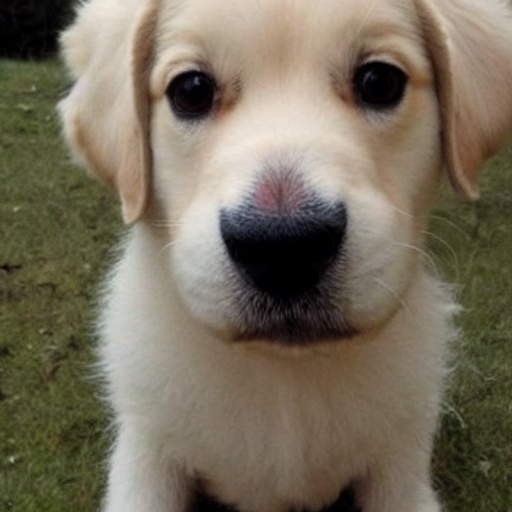

In [18]:
imgs = decode_img_latents(test_latents)
imgs[0]

## 4. Custom PipeLine 정의

In [19]:
def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                 guidance_scale=7.5, latents=None):
    if isinstance(prompts, str):
        prompts = [prompts]
        
    # 1. Prompts => text embeds
    text_embeds = get_text_embeds(prompts)
    
    # 2. Text embeds -> img latents
    latents = produce_latents(
        text_embeds, height=height, width=width, latents=latents,
        num_inference_steps=num_inference_steps, guidance_scale=guidance_scale)
    
    # 3. Img latents -> imgs
    imgs = decode_img_latents(latents)
    
    return imgs

0it [00:00, ?it/s]

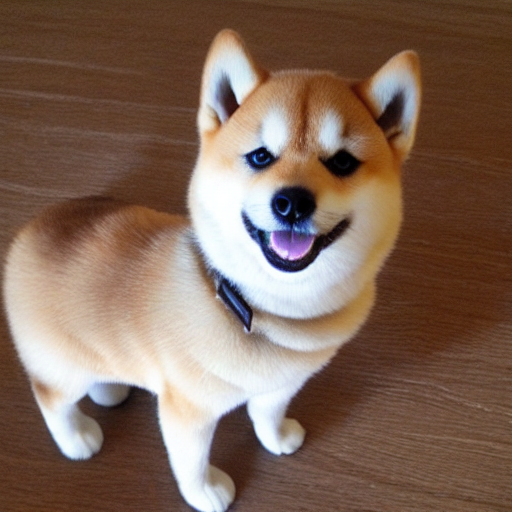

In [20]:
# test
prompt_to_img("Cute Shiba inu", 512, 512, 20)[0]